# **Sentiment Classification**

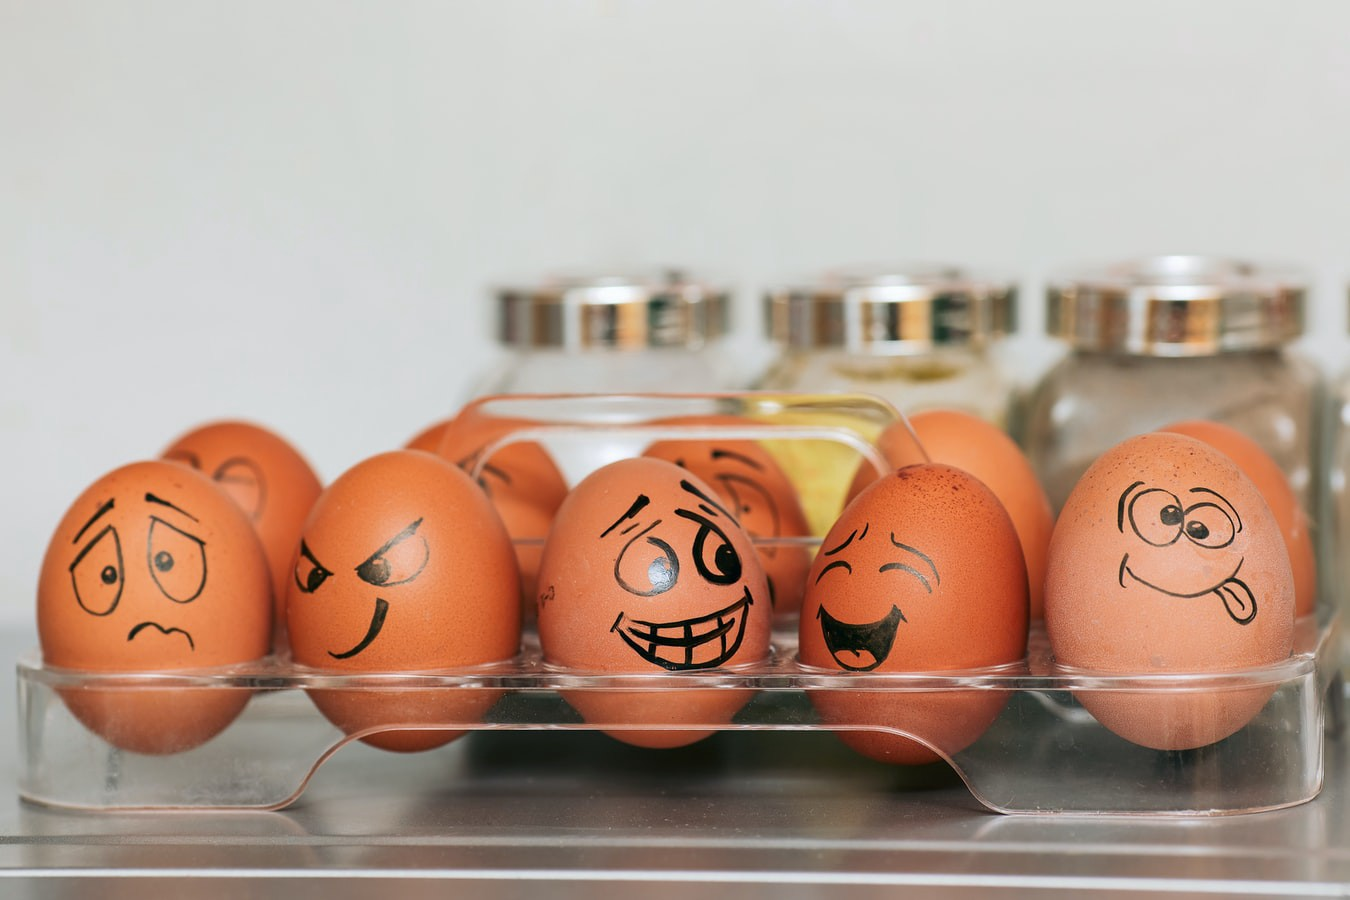

#“Torture the data, and it will confess to anything.” — Ronald Coase

In [1]:
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re 
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk 
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
train = pd.read_csv("Corona_NLP_train.csv")
test = pd.read_csv("Corona_NLP_test.csv")
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


###Data Cleaning

In [5]:
#function for removing @ -> tags
def remove_tags(inp, tags):
    r = re.findall(tags, inp)
    for i in r:
        inp = re.sub(i,'',inp)
    return inp
train['Tweet'] = np.vectorize(remove_tags)(train['OriginalTweet'], '@[\w]*')
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [6]:
import re

# remove website links
train['Tweet'] = train['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

# remove special characters, numbers, punctuations
train['Tweet'] = train['Tweet'].str.replace('[^a-zA-Z#]+',' ')

# remove short words
train['Tweet'] = train['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,ready supermarket during the #COVID outbreak Not because paranoid but because food stock litteraly empty The #coronavirus serious thing but please don panic causes shortage #CoronavirusFrance #res...


###Tokenization and Stemming

In [7]:
# create new variable tokenized tweet 
tokenized_tweet = train['Tweet'].apply(lambda x: x.split())

from nltk.stem.porter import *
stemmer = PorterStemmer()
# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0                                                                                                                                                                                                         []
1    [advic, talk, your, neighbour, famili, exchang, phone, number, creat, contact, list, with, phone, number, neighbour, school, employ, chemist, set, onlin, shop, account, poss, adequ, suppli, regula...
2                                                                                                        [coronaviru, australia, woolworth, give, elderli, disabl, dedic, shop, hour, amid, covid, outbreak]
3    [food, stock, not, the, onli, one, which, empti, pleas, don, panic, there, will, enough, food, for, everyon, you, not, take, more, than, you, need, stay, calm, stay, safe, #covid, franc, #covid, #...
4    [readi, supermarket, dure, the, #covid, outbreak, not, becaus, paranoid, but, becaus, food, stock, litterali, empti, the, #coronaviru, seriou, thing, but, pleas, don, panic, c

In [8]:
# joining tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# print(tokenized_tweet)
train['Tweet'] = tokenized_tweet
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...


###Create wordcloud of word influence

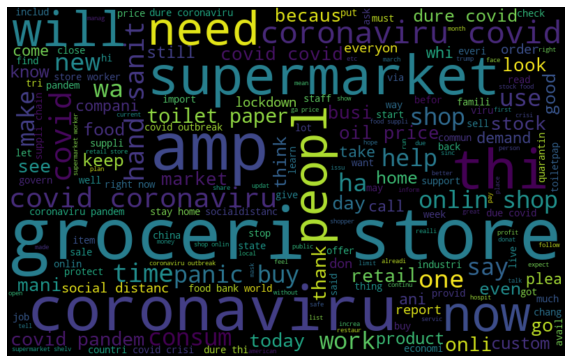

In [9]:
#from all tweets
all_words = ' '.join([text for text in train['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###Create wordcloud based on influence of words in Negative tweets

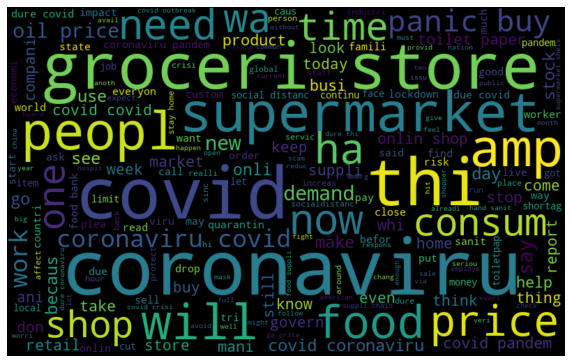

In [ ]:
normal_words = ' '.join([text for text in train['Tweet'][train['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

###Create wordcloud based on influence of words in Neutral tweets

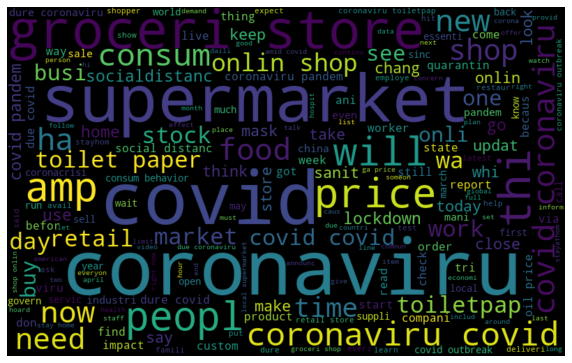

In [ ]:
normal_words = ' '.join([text for text in train['Tweet'][train['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [10]:
new_train = train[['Tweet','Sentiment']]
new_train.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
new_train['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

In [13]:
new_train.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


##Repeating above steps for testing dataset 

In [14]:
import re
#function for removing @ -> tags
def remove_tags(inp, tags):
    r = re.findall(tags, inp)
    for i in r:
        inp = re.sub(i,'',inp)
    return inp
test['Tweet'] = np.vectorize(remove_tags)(test['OriginalTweet'], '@[\w]*')

# remove website links
test['Tweet'] = test['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

# remove special characters, numbers, punctuations
test['Tweet'] = test['Tweet'].str.replace('[^a-zA-Z#]+',' ')

# remove short words
test['Tweet'] = test['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr...",Extremely Negative,TRENDING New Yorkers encounter empty supermarket shelves pictured Wegmans Brooklyn sold out online grocers FoodKick MaxDelivery #coronavirus fearing shoppers stock
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive,Find out how you can protect yourself and loved ones from #coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next ...,Neutral,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid News #Corvid NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next everyone buyi...


In [15]:
# create new variable tokenized tweet 
tokenized_test_tweet = test['Tweet'].apply(lambda x: x.split())

from nltk.stem.porter import *
stemmer = PorterStemmer()
# apply stemmer for tokenized_test_tweet
tokenized_test_tweet = tokenized_test_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_test_tweet.head()

0                                     [trend, new, yorker, encount, empti, supermarket, shelv, pictur, wegman, brooklyn, sold, out, onlin, grocer, foodkick, maxdeliveri, #coronaviru, fear, shopper, stock]
1                                                             [when, couldn, find, hand, sanit, fred, meyer, turn, #amazon, but, for, pack, purel, check, out, how, #coronaviru, concern, are, drive, price]
2                                                                                                                           [find, out, how, you, can, protect, yourself, and, love, one, from, #coronaviru]
3             [#panic, buy, hit, #newyork, citi, anxiou, shopper, stock, food, amp, medic, suppli, after, #healthcar, worker, her, becom, #bigappl, confirm, #coronaviru, patient, #bloomberg, stage, event]
4    [#toiletpap, #dunnypap, #coronaviru, #coronavirusaustralia, #coronavirusupd, #covid, new, #corvid, newsmelb, #dunnypaperg, #costco, one, week, everyon, buy, babi, milk, powder

In [16]:
# joining tokens into one sentence
for i in range(len(tokenized_test_tweet)):
    tokenized_test_tweet[i] = ' '.join(tokenized_test_tweet[i])
# print(tokenized_test_tweet)
test['Tweet'] = tokenized_test_tweet
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr...",Extremely Negative,trend new yorker encount empti supermarket shelv pictur wegman brooklyn sold out onlin grocer foodkick maxdeliveri #coronaviru fear shopper stock
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,when couldn find hand sanit fred meyer turn #amazon but for pack purel check out how #coronaviru concern are drive price
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive,find out how you can protect yourself and love one from #coronaviru
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#panic buy hit #newyork citi anxiou shopper stock food amp medic suppli after #healthcar worker her becom #bigappl confirm #coronaviru patient #bloomberg stage event
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next ...,Neutral,#toiletpap #dunnypap #coronaviru #coronavirusaustralia #coronavirusupd #covid new #corvid newsmelb #dunnypaperg #costco one week everyon buy babi milk powder the next everyon buy toilet paper


In [17]:
new_test = test[['Tweet','Sentiment']]
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')
new_test['Tweet'].apply(lambda x: [item for item in x if item not in stop])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       [r, e, n,  , n, e, w,  , r, k, e, r,  , e, n, c, u, n,  , e, p,  , u, p, e, r, r, k, e,  , h, e, l, v,  , p, c, u, r,  , w, e, g, n,  , b, r, k, l, n,  , l,  , u,  , n, l, n,  , g, r, c, e, r,  , ...
1       [w, h, e, n,  , c, u, l, n,  , f, n,  , h, n,  , n,  , f, r, e,  , e, e, r,  , u, r, n,  , #, z, n,  , b, u,  , f, r,  , p, c, k,  , p, u, r, e, l,  , c, h, e, c, k,  , u,  , h, w,  , #, c, r, n, ...
2                                                                             [f, n,  , u,  , h, w,  , u,  , c, n,  , p, r, e, c,  , u, r, e, l, f,  , n,  , l, v, e,  , n, e,  , f, r,  , #, c, r, n, v, r, u]
3       [#, p, n, c,  , b, u,  , h,  , #, n, e, w, r, k,  , c,  , n, x, u,  , h, p, p, e, r,  , c, k,  , f,  , p,  , e, c,  , u, p, p, l,  , f, e, r,  , #, h, e, l, h, c, r,  , w, r, k, e, r,  , h, e, r, ...
4       [#, l, e, p, p,  , #, u, n, n, p, p,  , #, c, r, n, v, r, u,  , #, c, r, n, v, r, u, u, r, l,  , #, c, r, n, v, r, u, u, p,  , #, c, v,  , n, e, w,  , #, c, r, 

In [18]:
new_test.head()

,Tweet,Sentiment
0,trend new yorker encount empti supermarket shelv pictur wegman brooklyn sold out onlin grocer foodkick maxdeliveri #coronaviru fear shopper stock,Extremely Negative
1,when couldn find hand sanit fred meyer turn #amazon but for pack purel check out how #coronaviru concern are drive price,Positive
2,find out how you can protect yourself and love one from #coronaviru,Extremely Positive
3,#panic buy hit #newyork citi anxiou shopper stock food amp medic suppli after #healthcar worker her becom #bigappl confirm #coronaviru patient #bloomberg stage event,Negative
4,#toiletpap #dunnypap #coronaviru #coronavirusaustralia #coronavirusupd #covid new #corvid newsmelb #dunnypaperg #costco one week everyon buy babi milk powder the next everyon buy toilet paper,Neutral


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

train = new_train
test = new_test

stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_test = vectorizer.transform(test.Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (41157, 30776)
X_test.shape :  (3798, 30776)
y_train.shape :  (41157,)
y_test.shape :  (3798,)


##Multi-class Naive Bayes classifier

training accuracy Score    :  0.6821925796340841
Testing accuracy Score :  0.4389152185360716
                    precision    recall  f1-score   support

Extremely Negative       0.33      0.57      0.42       338
Extremely Positive       0.33      0.66      0.44       302
          Negative       0.52      0.42      0.47      1300
           Neutral       0.26      0.58      0.36       277
          Positive       0.60      0.36      0.45      1581

          accuracy                           0.44      3798
         macro avg       0.41      0.52      0.43      3798
      weighted avg       0.50      0.44      0.44      3798

Confusion matrix
[[194   2 315   6  75]
 [  4 198  46  10 341]
 [ 93  18 545  54 331]
 [ 12  10 169 162 266]
 [ 35  74 225  45 568]]


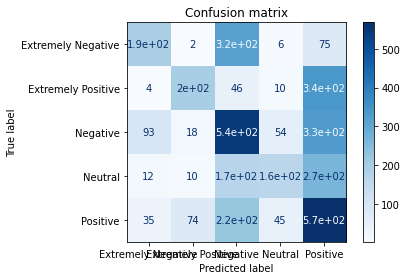

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Testing accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

# Plot confusion matrix
titles_options = [("Confusion matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(naiveByes_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.tight_layout()

    print(title)
    print(disp.confusion_matrix)

##Stochastic Gradient Descent Multi-class Classifier

Training accuracy Score    :  0.8041645406613699
Testing accuracy Score :  0.557925223802001
                    precision    recall  f1-score   support

Extremely Negative       0.68      0.57      0.62       706
Extremely Positive       0.67      0.66      0.67       611
          Negative       0.39      0.52      0.45       779
           Neutral       0.78      0.56      0.65       863
          Positive       0.44      0.50      0.47       839

          accuracy                           0.56      3798
         macro avg       0.59      0.56      0.57      3798
      weighted avg       0.59      0.56      0.57      3798

Confusion matrix
[[403   3 122  28  36]
 [ 15 404  24  19 137]
 [219  37 407 172 206]
 [ 18  12  64 485  40]
 [ 51 155 162 159 420]]


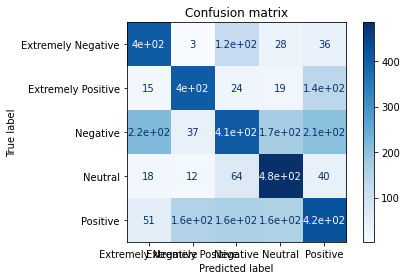

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

# Plot confusion matrix
titles_options = [("Confusion matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(sgd_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.tight_layout()

    print(title)
    print(disp.confusion_matrix)

##Support Vector Machine Multi-class Classification

Training accuracy Score    :  0.8984862842286853
Testing accuracy Score :  0.564507635597683
                    precision    recall  f1-score   support

Extremely Negative       0.42      0.71      0.52       348
Extremely Positive       0.50      0.74      0.59       403
          Negative       0.55      0.52      0.54      1111
           Neutral       0.70      0.61      0.65       712
          Positive       0.63      0.49      0.55      1224

          accuracy                           0.56      3798
         macro avg       0.56      0.61      0.57      3798
      weighted avg       0.59      0.56      0.57      3798

Confusion matrix
[[246   7 273  23  43]
 [  5 297  25  18 254]
 [ 71  21 576 131 242]
 [  5   4  88 431  91]
 [ 21  74 149 109 594]]


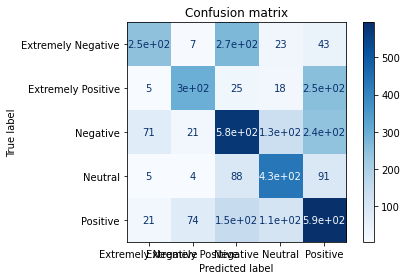

In [22]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_test))

# Plot confusion matrix
titles_options = [("Confusion matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.tight_layout()

    print(title)
    print(disp.confusion_matrix)

##Logistic Regression Multi-class classification

Training accuracy Score    :  0.8714434968535122
Testing accuracy Score :  0.610057925223802
                    precision    recall  f1-score   support

Extremely Negative       0.56      0.67      0.61       502
Extremely Positive       0.63      0.72      0.67       529
          Negative       0.56      0.56      0.56      1039
           Neutral       0.71      0.64      0.67       692
          Positive       0.61      0.56      0.58      1036

          accuracy                           0.61      3798
         macro avg       0.62      0.63      0.62      3798
      weighted avg       0.61      0.61      0.61      3798

Confusion matrix
[[194   2 315   6  75]
 [  4 198  46  10 341]
 [ 93  18 545  54 331]
 [ 12  10 169 162 266]
 [ 35  74 225  45 568]]


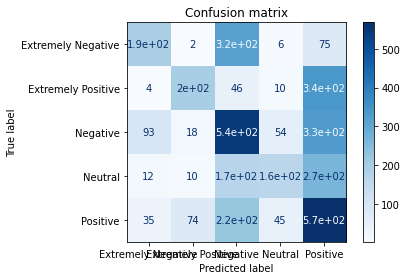

In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

# Plot confusion matrix
titles_options = [("Confusion matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(naiveByes_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.figure_.tight_layout()

    print(title)
    print(disp.confusion_matrix)

#Interesting Observations from the above train dataset

##Unique values in each column

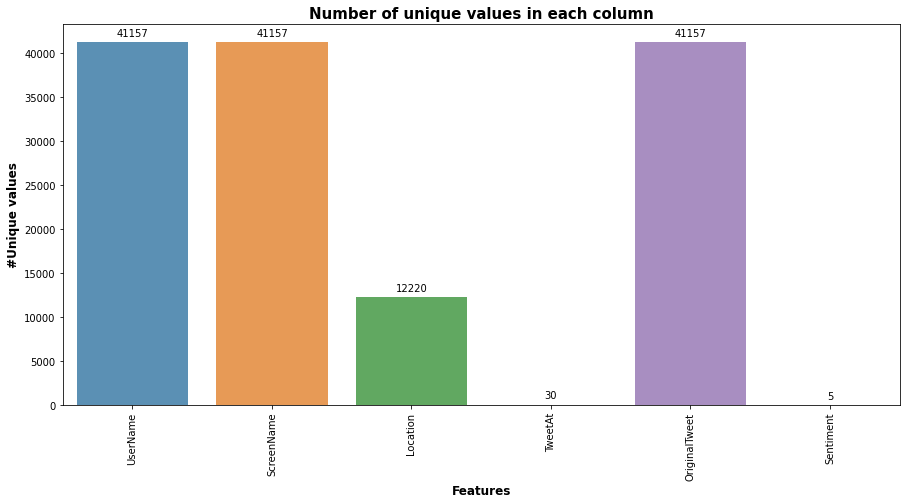

In [ ]:
unique_values = pd.DataFrame()
unique_values['Features'] = train.columns
unique=[]
for i in train.columns:
    unique.append(train[i].nunique())
unique_values['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_values['Features'], y=unique_values['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

##Top 12 locations of the tweets

In [ ]:
import plotly.graph_objects as go

loc_analysis = pd.DataFrame(train['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})

data = {
   "values": loc_analysis['count'][:12],
   "labels": loc_analysis.index[:12],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

##Tweet dates

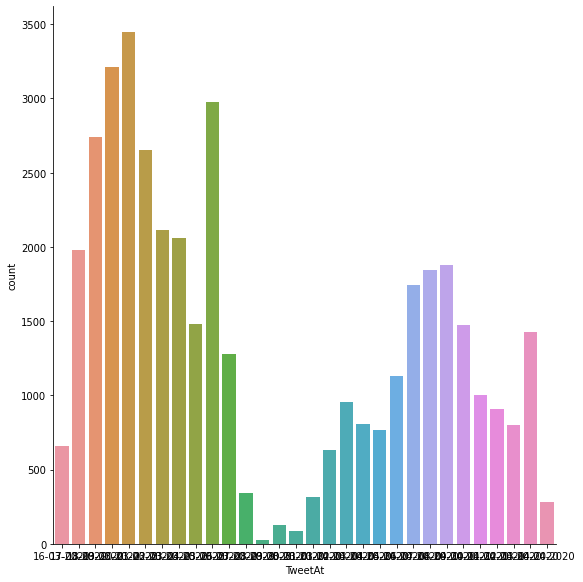

In [ ]:
sns.catplot("TweetAt", data=train, kind="count", height=8)

##Plot of Sentiments Count

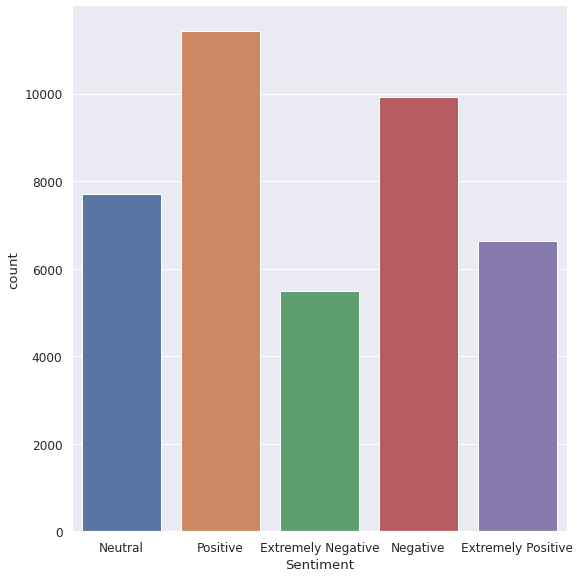

In [ ]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=train, kind="count", height=8)

##Top 10 tweet places

In [ ]:
top_tweet_locations= train['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

top_tweet_locations_df=pd.DataFrame(top_tweet_locations)
top_tweet_locations_df.reset_index(inplace=True)
top_tweet_locations_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
top_tweet_locations_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(0, 0, 'United States'),
 Text(0, 0, 'London, England'),
 Text(0, 0, 'New York, NY'),
 Text(0, 0, 'Washington, DC'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Los Angeles, CA'),
 Text(0, 0, 'India'),
 Text(0, 0, 'UK'),
 Text(0, 0, 'Australia')]

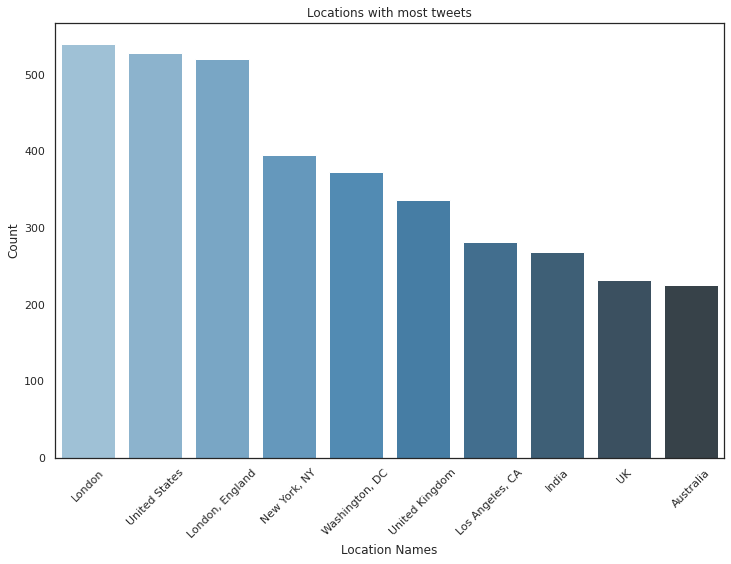

In [ ]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=top_tweet_locations_df,palette='Blues_d')
viz_1.set_title('Locations with most tweets')
viz_1.set_ylabel('Count')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

#Classification using Neural Networks

In [ ]:
import re
import chardet 
import operator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D

from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
train = pd.read_csv("sample_data/Corona_NLP_train.csv")
test = pd.read_csv("sample_data/Corona_NLP_test.csv")
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


###Data Cleaning
Extracting the following and removing them:
1. Hashtags
2. Handles
3. Links to websites
4. HTML tags
5. Numbers and symbols

In [ ]:
train["hashtag"] = train["OriginalTweet"].apply(lambda x: re.findall(r"#(\w+)", x))

train["url"] = train["OriginalTweet"].apply(lambda x : re.findall(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', x))

train["handler"] = train["OriginalTweet"].apply(lambda x: re.findall(r"@(\w+)", x))

####Lemmatizing

In [ ]:
def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()


####Applying to the data and cleaning it

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
regex = [
    r'<[^>]+>', #HTML tags
    r'@(\w+)', # handles
    r"#(\w+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^0-9a-z #+_\\r\\n\\t]', # numbers and unnecessary symbols
]

REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
REPLACE_BY = re.compile(r"[^a-z0-9\-]")

STOPWORDS = set(stopwords.words('english'))

sentences = [] #for Word2Vec model

def clean_text(text):
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    text = REPLACE_URLS.sub('', text)
    text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    text = REPLACE_BY.sub(' ', text)
    
    text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) for word in text.split() if word not in STOPWORDS and len(word)>3)
    return (text, text.split())

train["Tweet"], train["sentences"] = zip(*train["OriginalTweet"].apply(clean_text))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
test["Tweet"], test["sentences"] = zip(*test["OriginalTweet"].apply(clean_text))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
pd.set_option('display.max_colwidth', None)
train.Tweet[10:15]

10                     month crowd supermarket restaurant however reduce hour closing mall mean everyone use entrance dependent single supermarket
11          covid-19 situation increase demand food product wait time longer online order particularly beef share freezer pack thank patience time
12    care community look less capable village ensure stay healthy bring shopping door help online shopping self isolation symptom expose somebody
13                                                                                             need stock food amazon deliver whatever need amazon
14                    adara release covid-19 resource center travel brand insight help travel brand stay up-to-date consumer travel behavior trend
Name: Tweet, dtype: object

In [ ]:
import numpy as np
max_len = np.max(train["Tweet"].apply(lambda x: len(x)))

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train["Tweet"].values)

vocab_size = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(train["Tweet"].values)
X = pad_sequences(X, maxlen=max_len, padding='post')

In [ ]:
X_test = tokenizer.texts_to_sequences(test["Tweet"].values)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [ ]:
from time import sleep
from tqdm import tqdm
import numpy as np

In [ ]:
embeddings_index = {}
glovefile = open('drive/MyDrive/Classroom/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:34, 11723.43it/s]

Found 400000 word vectors.


In [ ]:
#embedding matrix for the words in dataset
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

100%|██████████| 25697/25697 [00:00<00:00, 331567.62it/s]


In [ ]:
X.shape,X_test.shape

((41157, 249), (3798, 249))

In [ ]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']
           

train["Sentiment"].replace(encoding, inplace=True)
test["Sentiment"].replace(encoding, inplace=True)

In [ ]:
labels = pd.get_dummies(train["Sentiment"]).columns
y = pd.get_dummies(train["Sentiment"]).values
y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
y_test = pd.get_dummies(test["Sentiment"]).values
y_test.shape

(3798, 3)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=12)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(32925, 249) (32925, 3)
(8232, 249) (8232, 3)


In [ ]:
vector_features = 300
model = Sequential()
model.add(Embedding(vocab_size, vector_features, input_length=X.shape[1], weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.2))

model.add(Bidirectional(LSTM(300, activation='relu', dropout=0.3, recurrent_dropout=0.3), input_shape=(vector_features, vocab_size)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 249, 300)          7709400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 249, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 1024)              615424    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

In [ ]:
epochs = 10
batch_size = 512

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
65/65 [==============================] - 2273s 35s/step - loss: 0.9314 - accuracy: 0.5498 - val_loss: 0.7676 - val_accuracy: 0.6914
Epoch 2/10
65/65 [==============================] - 2215s 34s/step - loss: 0.7555 - accuracy: 0.6805 - val_loss: 0.6761 - val_accuracy: 0.7329
Epoch 3/10
65/65 [==============================] - 2163s 33s/step - loss: 0.6955 - accuracy: 0.7162 - val_loss: 0.6266 - val_accuracy: 0.7601
Epoch 4/10
65/65 [==============================] - 2207s 34s/step - loss: 0.6501 - accuracy: 0.7404 - val_loss: 0.5867 - val_accuracy: 0.7758
Epoch 5/10
65/65 [==============================] - 2199s 34s/step - loss: 0.6184 - accuracy: 0.7561 - val_loss: 0.5789 - val_accuracy: 0.7795
Epoch 6/10
65/65 [==============================] - 2198s 34s/step - loss: 0.5843 - accuracy: 0.7718 - val_loss: 0.5508 - val_accuracy: 0.7861
Epoch 7/10
65/65 [==============================] - 2182s 34s/step - loss: 0.5623 - accuracy: 0.7802 - val_loss: 0.5343 - val_accuracy: 0.7930

In [ ]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

print("training acuuracy {0}% and training loss {1}%".format(accuracy[-1]*100, loss[-1]*100))
print("validation acuuracy {0}% and validation loss {1}%".format(val_accuracy[-1]*100, val_loss[-1]*100))

training acuuracy 81.03872537612915% and training loss 50.104379653930664%
validation acuuracy 80.90379238128662% and validation loss 50.75543522834778%


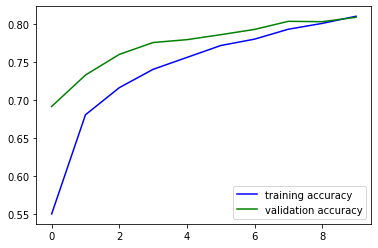

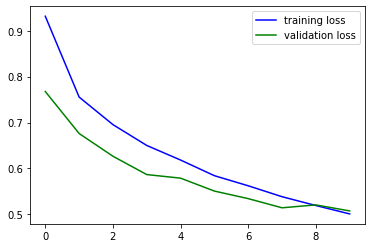

In [ ]:
plt.plot(accuracy,'b',label='training accuracy')
plt.plot(val_accuracy, 'g', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'b',label='training loss')
plt.plot(val_loss, 'g', label='validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

print(labels[np.argmax(y_test, 1)][10:12])
print(labels[np.argmax(y_pred, 1)][10:12])

Int64Index([2, 0], dtype='int64')
Int64Index([2, 0], dtype='int64')


In [ ]:
y_pred = np.round(y_pred)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))
lstm_accuracy = accuracy_score(y_test,y_pred)
print("Testing accuracy Score : ",lstm_accuracy )
print(classification_report(y_pred,y_test))

print(cm)


Testing accuracy Score :  0.764612954186414
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1615
           1       0.71      0.72      0.72       608
           2       0.74      0.88      0.80      1299

   micro avg       0.76      0.82      0.79      3522
   macro avg       0.75      0.81      0.78      3522
weighted avg       0.77      0.82      0.79      3522
 samples avg       0.76      0.76      0.76      3522

[[1417  101  115]
 [ 132  440   47]
 [ 342   67 1137]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


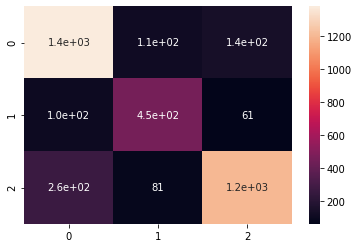

In [ ]:
sns.heatmap(cm, annot=True)

#Conclusion
The project used  tweet sentiment analysis as a way of  accessing written comments to decide whether articulation is positive, negative or neutral and to what degree. Various machine learning and NLP approaches were explored.  It was observed that among machine learning models, logistic regression gave highest accuracy of 59%, whereas Bi-directional LSTM gave accuracy as high as  76.46%   . 

Interesting area for future study includes the fluctuations in the performance of sentiment analysis algorithms in cases where multiple features are considered. In other words, combining various features was found to lead to improve the performance in most cases, but substandard performance in others.

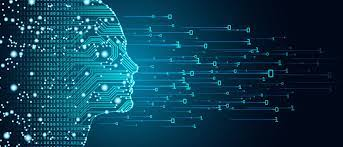

#Thank You
